Advanced Machine Learning project
- Merlo Riccardo, 829805
- Riva Leonardo, 830647

Dataset: https://www.kaggle.com/c/mercari-price-suggestion-challenge/overview


# Libraries

In [ ]:
# !pip install -U kaggle
# !pip install pyunpack
# !pip install patool
# from pyunpack import Archive

In [ ]:
# general
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image

# nlp
import re
from collections import Counter
import nltk
import string
from gensim.models import KeyedVectors
from gensim import models
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# ml
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, LSTM, GRU, Embedding, Flatten, Bidirectional, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import mean_squared_logarithmic_error
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

# drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Università/5/Advanced ML/progetto/' #'/content/drive/MyDrive/'

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') 
STOPWORDS = set(stopwords.words('english'))
PUNCTUATIONS = string.punctuation + '•'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Functions

In [ ]:
# flatten a nested list
def flatten(t):
    return [item for sublist in t for item in sublist]

In [ ]:
def preprocess(df):
  # delete useless id
  df.drop(columns=['train_id', 'test_id'], errors='ignore')

  # rename
  df.rename(columns={'brand_name': 'brand', 
                    'item_description': 'description', 
                    'item_condition_id': 'condition',
                    'category_name': 'category'}, inplace=True)

  # lowercase entire dataframe
  for col in ['name', 'brand', 'category', 'description']:
      df[col] = df[col].str.lower() 

  # split categories
  df[['category1', 'category2', 'category3']] = df['category'].str.split('/', 2, expand=True)

  # log price (if present)
  if 'price' in df.columns:
    df['price'] = np.log(df['price']+1)

  # missing values
  df.fillna('missing', inplace=True)

  # add description length
  df['desc_len'] = df['description'].apply(lambda x: len(x))

  # add brand in name
  df['is_brand_in_name'] = df.apply(lambda x: 1 if x['brand'] in x['name'] else 0, axis=1)

  # clean name and description
  df['description'] = clean_text_feature(df['description'])
  df['name'] = clean_text_feature(df['name'], complete=False)

  # select and re-order columns
  cols = ['name', 'description', 'brand', 'desc_len', 'is_brand_in_name', 'category1', 'category2', 'category3', 'condition', 'shipping']
  if 'price' in df.columns:
    cols.append('price')
  df = df[cols]

  return df

In [ ]:
def clean_text_feature(col, complete=True):
    col = col.str.replace('no description yet', 'missing')
    col = col.str.replace('[rm]', '', regex=False)
    if complete:
        col = col.str.replace('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', regex=True) 
        col = col.apply(lambda x: remove_stopwords(x))
    col = col.apply(lambda x: remove_emoji(x))
    col = col.apply(lambda x: remove_punctuation(x))
    col = col.apply(lambda x: remove_whitespaces(x))
    col = col.apply(lambda x: correct_sentence(x))
    col = col.apply(lambda x: x if any(c.isalpha() for c in x) else 'missing') # se c'è almeno una lettera
    return col

In [ ]:
def remove_stopwords(text):
  return ' '.join([word for word in text.split() if word not in STOPWORDS])


def remove_punctuation(text):
    trans = str.maketrans(dict.fromkeys(PUNCTUATIONS, ' '))
    return text.translate(trans)


def remove_emoji(text):
  emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              u"\U00002500-\U00002BEF"  # chinese char
                              u"\U00002702-\U000027B0"
                              u"\U00002702-\U000027B0"
                              u"\U000024C2-\U0001F251"
                              u"\U0001f926-\U0001f937"
                              u"\U00010000-\U0010ffff"
                              u"\u2640-\u2642"
                              u"\u2600-\u2B55"
                              u"\u200d"
                              u"\u23cf"
                              u"\u23e9"
                              u"\u231a"
                              u"\ufe0f"  # dingbats
                              u"\u3030"
                              "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)


def remove_whitespaces(text):
  return " ".join(text.split()).strip()


def correct_sentence(sentence):
  s = re.sub(r"(.)\1+", r'\1\1', sentence)
  # return ' '.join([correction(word) for word in s.split()])
  return s

In [ ]:
# encode categorical data into integers
def columns2categorical(df_train, df_val, df_test, columns):
  for col in columns:
    le = LabelEncoder()
    le.fit(np.hstack([df_train[col], df_val[col], df_test[col]]))
    df_train[col] = le.transform(df_train[col])
    df_val[col] = le.transform(df_val[col])
    df_test[col] = le.transform(df_test[col])
  return df_train, df_val, df_test

In [ ]:
def split_df(train, val_size, test_size):
  X_train = train.copy()
  del X_train['price']
  y_train = train[['price']]

  X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=123)

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=456)

  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
def read_files():
  X_train = pd.read_csv(path+'X_train.csv')
  X_val = pd.read_csv(path+'X_val.csv')
  X_test = pd.read_csv(path+'X_test.csv')
  y_train = pd.read_csv(path+'y_train.csv')
  y_val = pd.read_csv(path+'y_val.csv')
  y_test = pd.read_csv(path+'y_test.csv')
  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
def tokenize_string_columns(df_train, df_val, df_test, columns):
  raw_text = np.hstack([df_train[col] for col in columns])

  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(raw_text)

  for df in [df_train, df_val, df_test]:
    for col in columns:
      df['seq_'+col] = tokenizer.texts_to_sequences(df[col])

  return df_train, df_val, df_test

In [ ]:
def calc_rmsle(model, X, y):
  groundtruth = np.exp(y)-1
  predictions = np.exp(model.predict(X))-1
  return np.sqrt(mean_squared_log_error(groundtruth, predictions))

In [ ]:
def bertTokenize(docs, tokenizer, max_len):
  input_ids = []
  attention_masks = []
  for doc in docs:
    bert_inp = tokenizer.encode_plus(doc, add_special_tokens = True, max_length = max_len, padding = 'max_length', return_attention_mask = True, truncation=True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])
  return np.array(input_ids, dtype='int32'), np.array(attention_masks, dtype='int32')

In [ ]:
def create_embed_matrix(model, word_index, num_tokens, embed_dim=300):
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embed_dim))
  for word, i in word_index.items():
      
      #embedding_vector = model[word] #embeddings_index.get(word)
      if word in model:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = model[word]
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))

  return embedding_matrix

# Download Dataset

In [ ]:
# ! mkdir ~/.kaggle
# ! cp "drive/MyDrive/Università/5/Advanced ML/progetto/kaggle.json" ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c mercari-price-suggestion-challenge

# Archive('train.tsv.7z').extractall('/content')
# Archive('test.tsv.7z').extractall('/content')

In [ ]:
train = pd.read_csv(path+'train.tsv', sep='\t')
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


# Exploration

In [ ]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [ ]:
train.isnull().sum() * 100 / len(train)

train_id              0.000000
name                  0.000000
item_condition_id     0.000000
category_name         0.426769
brand_name           42.675687
price                 0.000000
shipping              0.000000
item_description      0.000270
dtype: float64

In [ ]:
train[train['price']>1000] # per vedere cosa costa tanto

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1971,1971,Chanel Classic Flag Bag medium Caviar L,3,Women/Women's Handbags/Shoulder Bag,Chanel,1506.0,0,No description yet
15769,15769,Celine Tri Colored Suede Mini luggage,3,Women/Women's Handbags/Totes & Shoppers,Celine,1009.0,0,Beautiful Celine mini luggage. In good conditi...
19599,19599,Alexander McQueen Crystal Knuckle Clutch,1,Vintage & Collectibles/Bags and Purses/Clutch,Alexander McQueen,1109.0,0,Alexander McQueen Knuckle Duster Multi Color C...
19621,19621,"Tiffany wedding band originally [rm],000",3,Women/Jewelry/Rings,Tiffany & Co.,1004.0,0,Tiffany's wedding band selling for half the pr...
21693,21693,YSL purse and shoes combo,1,Women/Women's Handbags/Shoulder Bag,Saint Laurent,1206.0,0,YSL small monogram purse (new) and skate shoes...
...,...,...,...,...,...,...,...,...
1431080,1431080,Gucci Soho Disco Bag,2,Women/Women's Handbags/Messenger & Crossbody,Gucci,1056.0,0,Selling new Gucci soho disco in dusty pink. Th...
1445348,1445348,Vs2/I 1ct Diamond Engagement Ring,2,Women/Jewelry/Rings,NaN,2000.0,1,Absolutely stunning diamond engagement ring Pu...
1467815,1467815,Apple MacBook WINTAWONDERLAND,2,Electronics/Computers & Tablets/Laptops & Netb...,Apple,1259.0,0,2016 Apple MacBook with Beats wireless headpho...
1468729,1468729,2017 Apple MacBook Pro Space Gray,1,Electronics/Computers & Tablets/Laptops & Netb...,Apple,1708.0,0,Brand New in Box 2017 Macbook Pro w/ TOUCH BAR...


In [ ]:
# 1 - New
# 2 - Like New
# 3 - Good
# 4 - Fair
# 5 - Poor
set(train['item_condition_id'])

{1, 2, 3, 4, 5}

In [ ]:
len(set(train['brand_name']))

4810

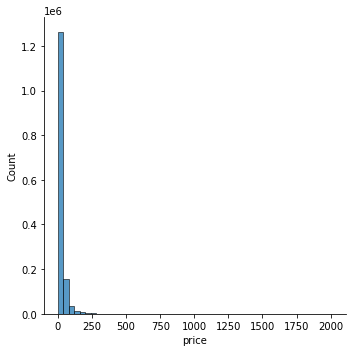

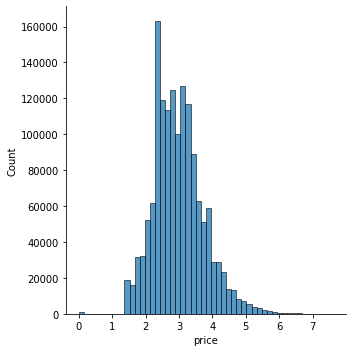

In [ ]:
sns.displot(train['price'], bins=50)
sns.displot(np.log(train['price']+1), bins=50)

# Preprocessing

In [ ]:
train = preprocess(train)

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_df(train, val_size=.1, test_size=.1)

In [ ]:
X_train, X_val, X_test = columns2categorical(X_train, X_val, X_test, ['brand', 'category1', 'category2', 'category3'])

In [ ]:
X_train.head()

,name,description,brand,desc_len,is_brand_in_name,category1,category2,category3,condition,shipping
783307,mossimo mustard yellow laser cut flats,fun pair flats summer well almost 3 4 inch tal...,2990,236,0,10,88,324,2,1
567619,mafia 3 ps4 like new with codes,like new played once comes pre order codes,4047,49,0,1,109,344,2,1
350400,candies tote,gorgeous baby pink floral tote candies brand n...,817,191,0,10,112,795,1,1
264578,lularoe nicole xl dress,super soft stretchy fabric dark wine color bac...,2670,196,1,10,35,463,3,0
18838,lularoe holiday leggings os,brand new lularoe leggings one size,2076,36,0,10,5,578,1,1


In [ ]:
# # save files
# X_train.to_csv(path+'X_train.csv', index=False)
# X_val.to_csv(path+'X_val.csv', index=False)
# X_test.to_csv(path+'X_test.csv', index=False)
# y_train.to_csv(path+'y_train.csv', index=False)
# y_val.to_csv(path+'y_val.csv', index=False)
# y_test.to_csv(path+'y_test.csv', index=False)

# Exploration 2

In [ ]:
X_train.columns

Index(['brand', 'desc_len', 'is_brand_in_name', 'category1', 'category2',
       'category3', 'condition', 'shipping'],
      dtype='object')

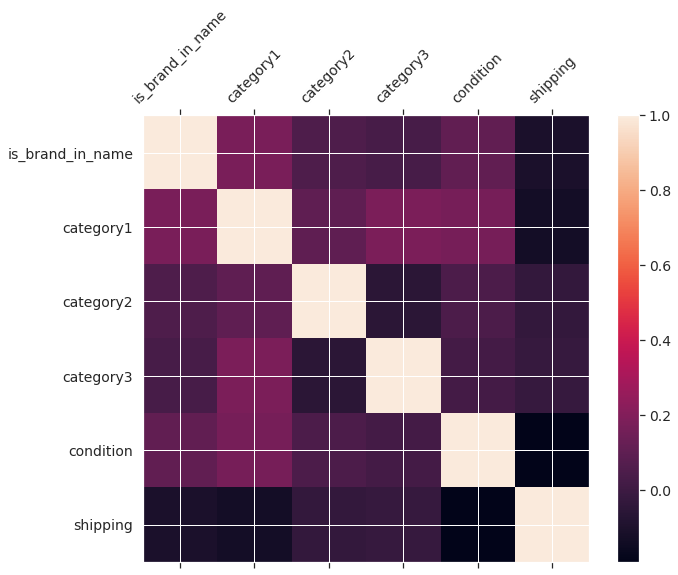

In [ ]:
tmp = X_train[['is_brand_in_name', 'category1', 'category2', 'category3', 'condition', 'shipping']]
f = plt.figure(figsize=(10,8))
plt.matshow(tmp.corr(), fignum=f.number)
plt.xticks(range(tmp.select_dtypes(['number']).shape[1]), tmp.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(tmp.select_dtypes(['number']).shape[1]), tmp.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
del tmp

In [ ]:
print(len(set(X_train['category1'])))
print(len(set(X_train['category2'])))
print(len(set(X_train['category3'])))

11
114
859


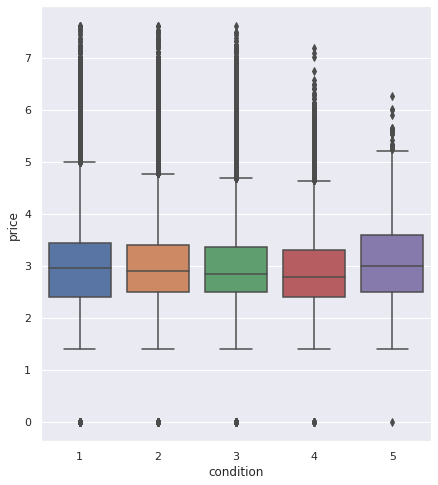

In [ ]:
sns.set(rc={'figure.figsize':(7,8)})
sns.boxplot(x=X_train['condition'], y=y_train['price'])

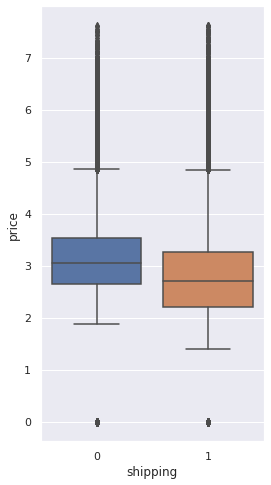

In [ ]:
sns.set(rc={'figure.figsize':(4,8)})
sns.boxplot(x=X_train['shipping'], y=y_train['price'])

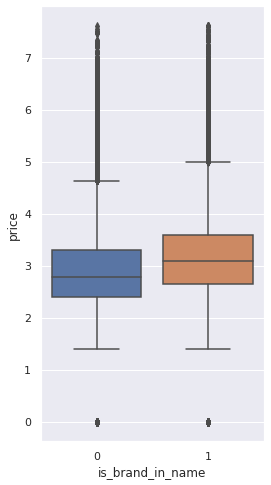

In [ ]:
sns.set(rc={'figure.figsize':(4,8)})
sns.boxplot(x=X_train['is_brand_in_name'], y=y_train['price'])

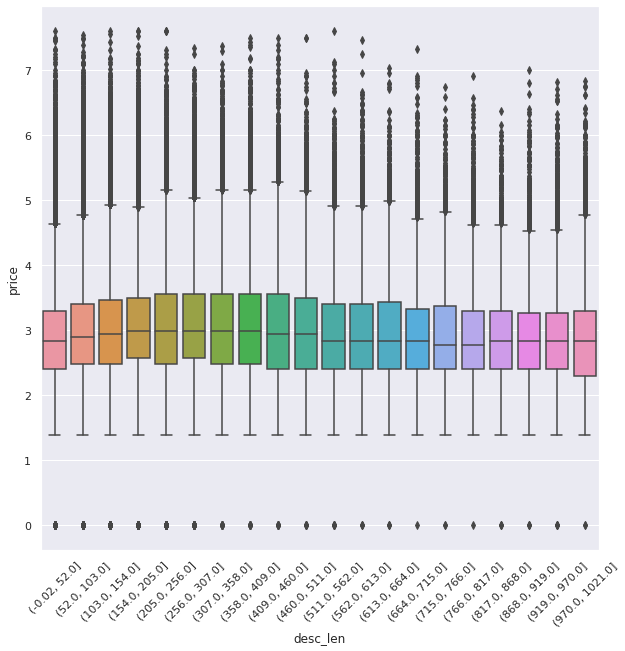

In [ ]:
tmp = pd.DataFrame()
tmp['desc_len'] = X_train['desc_len']
tmp['price'] = y_train['price']
tmp['desc_len'] = pd.cut(tmp['desc_len'], bins=20)
sns.set(rc={'figure.figsize':(10,10)})
plt.xticks(rotation=45)
sns.boxplot(x='desc_len', y='price', data=tmp)

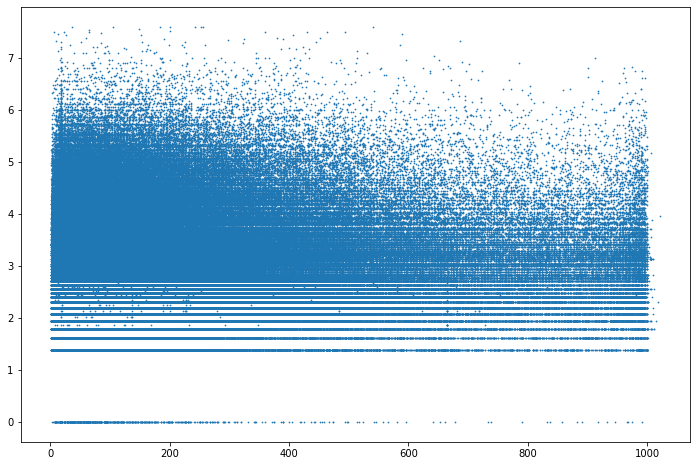

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)
plt.scatter(x=X_train['desc_len'], y=y_train['price'], s=0.5)

# Models

### Model 1
Without name and description

In [ ]:
del X_train['name'], X_train['description'], X_val['name'], X_val['description'], X_test['name'], X_test['description']

X_train.head()

,brand,desc_len,is_brand_in_name,category1,category2,category3,condition,shipping
0,2990,236,0,10,88,324,2,1
1,4047,49,0,1,109,344,2,1
2,817,191,0,10,112,795,1,1
3,2670,196,1,10,35,463,3,0
4,2076,36,0,10,5,578,1,1


In [ ]:
# normalize in [0,1]
scaler = MinMaxScaler(feature_range = (0, 1))
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
epochs = 100
batch_size = 512
patience = 3
optimizer = 'adam'
loss = mean_squared_logarithmic_error

In [ ]:
def create_model1():
  model = Sequential()
  model.add(Dense(1024, input_shape=(X_train.shape[1],), activation = 'relu'))
  model.add(Dropout(.2))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(.2))
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(.2))
  model.add(Dense(1, activation = 'linear'))
  return model

model1 = create_model1()

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              9216      
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6

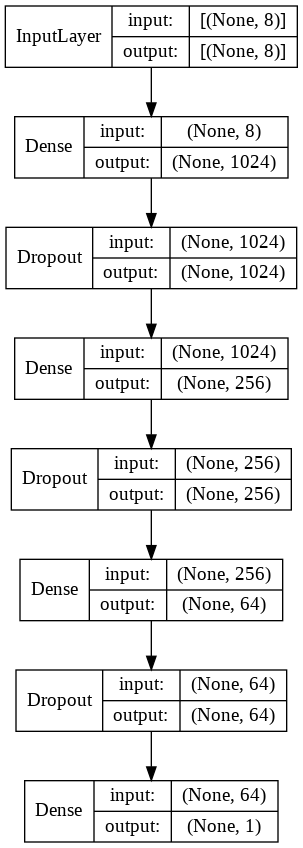

In [ ]:
plot_model(model1, show_layer_names=False, show_shapes=True)

In [ ]:
model1.compile(optimizer=optimizer, loss=loss)

stop_callback = EarlyStopping(monitor='val_loss', patience=patience)
save_callback = ModelCheckpoint(path+'best_model1.h5', save_best_only=True)

net_hist = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                     validation_data=(X_val, y_val), callbacks=[stop_callback, save_callback])

Epoch 1/100
2346/2346 [==============================] - 14s 6ms/step - loss: 0.0394 - val_loss: 0.0292
Epoch 2/100
2346/2346 [==============================] - 13s 6ms/step - loss: 0.0323 - val_loss: 0.0271
Epoch 3/100
2346/2346 [==============================] - 13s 6ms/step - loss: 0.0294 - val_loss: 0.0262
Epoch 4/100
2346/2346 [==============================] - 14s 6ms/step - loss: 0.0275 - val_loss: 0.0258
Epoch 5/100
2346/2346 [==============================] - 14s 6ms/step - loss: 0.0265 - val_loss: 0.0252
Epoch 6/100
2346/2346 [==============================] - 13s 6ms/step - loss: 0.0258 - val_loss: 0.0247
Epoch 7/100
2346/2346 [==============================] - 14s 6ms/step - loss: 0.0253 - val_loss: 0.0243
Epoch 8/100
2346/2346 [==============================] - 13s 6ms/step - loss: 0.0250 - val_loss: 0.0241
Epoch 9/100
2346/2346 [==============================] - 14s 6ms/step - loss: 0.0248 - val_loss: 0.0238
Epoch 10/100
2346/2346 [==============================] - 13s 6m

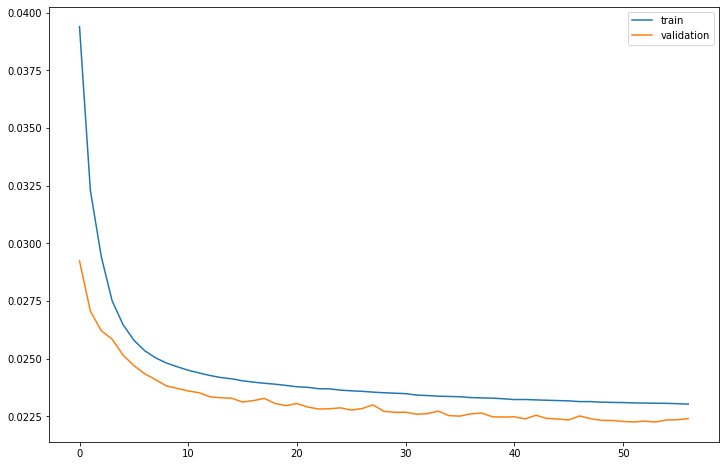

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)
plt.plot(net_hist.history['loss'], label='train')
plt.plot(net_hist.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.show()

In [ ]:
model1 = keras.models.load_model(path+'best_model1.h5')

In [ ]:
rmsle = calc_rmsle(model1, X_test, y_test)
print('rmsle:', np.round(rmsle,5))

rmsle: 0.59514


### Model 2
Keras embedding

In [ ]:
X_train, X_val, X_test = tokenize_string_columns(X_train, X_val, X_test, ['name', 'description'])
X_train.head()

,name,description,brand,desc_len,is_brand_in_name,category1,category2,category3,condition,shipping,seq_name,seq_description
0,mossimo mustard yellow laser cut flats,fun pair flats summer well almost 3 4 inch tal...,2990,236,0,10,88,324,2,1,"[2012, 2334, 291, 3200, 371, 884]","[567, 168, 884, 380, 219, 736, 15, 23, 444, 44..."
1,mafia 3 ps4 like new with codes,like new played once comes pre order codes,4047,49,0,1,109,344,2,1,"[10597, 15, 963, 26, 1, 306, 4282]","[26, 1, 1227, 163, 61, 776, 302, 4282]"
2,candies tote,gorgeous baby pink floral tote candies brand n...,817,191,0,10,112,795,1,1,"[5023, 464]","[370, 106, 10, 220, 464, 5023, 4, 1, 31, 30, 1..."
3,lularoe nicole xl dress,super soft stretchy fabric dark wine color bac...,2670,196,1,10,35,463,3,0,"[36, 1719, 103, 44]","[56, 89, 416, 395, 173, 1563, 24, 715, 3450, 5..."
4,lularoe holiday leggings os,brand new lularoe leggings one size,2076,36,0,10,5,578,1,1,"[36, 774, 51, 200]","[4, 1, 36, 51, 22, 2]"


In [ ]:
X_train_namedesc = X_train[['seq_name', 'seq_description']]
X_val_namedesc = X_val[['seq_name', 'seq_description']]
X_test_namedesc = X_test[['seq_name', 'seq_description']]

for df in [X_train, X_val, X_test]:
  del df['name'], df['seq_name'], df['description'], df['seq_description']

In [ ]:
# normalize in [0,1]
scaler = MinMaxScaler(feature_range = (0, 1))
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
# embeddings max values
MAX_SEQ_NAME = 10
MAX_SEQ_DESCRIPTION = 75

name_padded = pad_sequences(X_train_namedesc['seq_name'], maxlen=MAX_SEQ_NAME)
desc_padded = pad_sequences(X_train_namedesc['seq_description'], maxlen=MAX_SEQ_DESCRIPTION)
name_padded_val = pad_sequences(X_val_namedesc['seq_name'], maxlen=MAX_SEQ_NAME)
desc_padded_val = pad_sequences(X_val_namedesc['seq_description'], maxlen=MAX_SEQ_DESCRIPTION)
name_padded_test = pad_sequences(X_test_namedesc['seq_name'], maxlen=MAX_SEQ_NAME)
desc_padded_test = pad_sequences(X_test_namedesc['seq_description'], maxlen=MAX_SEQ_DESCRIPTION)

In [ ]:
tmp = set(flatten(X_train_namedesc['seq_name']))
tmp = tmp.union(set(flatten(X_val_namedesc['seq_name'])))
tmp = tmp.union(set(flatten(X_test_namedesc['seq_name'])))
tmp = tmp.union(set(flatten(X_train_namedesc['seq_description'])))
tmp = tmp.union(set(flatten(X_val_namedesc['seq_description'])))
tmp = tmp.union(set(flatten(X_test_namedesc['seq_description'])))
vocab_size = len(tmp)
del tmp

In [ ]:
epochs = 50
batch_size = 1024
patience = 4
optimizer = 'adam'
loss = mean_squared_logarithmic_error

In [ ]:
def create_model2(X_train):

  # define sets of inputs
  input = Input(shape=(X_train.shape[1],))
  input_name = Input(shape=(MAX_SEQ_NAME,), name='name')
  input_desc = Input(shape=(MAX_SEQ_DESCRIPTION,), name='description')

  # 1st branch
  l1 = Dense(64, activation="relu")(input)

  # 2nd branch
  l2 = Embedding(vocab_size, 32) (input_name)
  l2 = Bidirectional(LSTM(32, return_sequences=True, dropout=0.2)) (l2)
  l2 = GlobalMaxPooling1D()(l2)

  # 3rd branch
  l3 = Embedding(vocab_size, 32) (input_desc)
  l3 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)) (l3)
  l3 = GlobalMaxPooling1D()(l3)

  # combine branches
  combined = concatenate([l1, l2, l3])

  # final layer
  z = Dropout(0.2)(combined)
  z = Dense(128, activation="relu")(z)
  z = Dense(64, activation="relu")(z)
  z = Dense(1, activation="linear")(z)

  return Model(inputs=[input, input_name, input_desc], outputs=z)


model2 = create_model2(X_train)

In [ ]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 name (InputLayer)              [(None, 10)]         0           []                               
                                                                                                  
 description (InputLayer)       [(None, 75)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 10, 32)       6031008     ['name[0][0]']                   
                                                                                                  
 embedding_1 (Embedding)        (None, 75, 32)       6031008     ['description[0][0]']            
                                                                                              

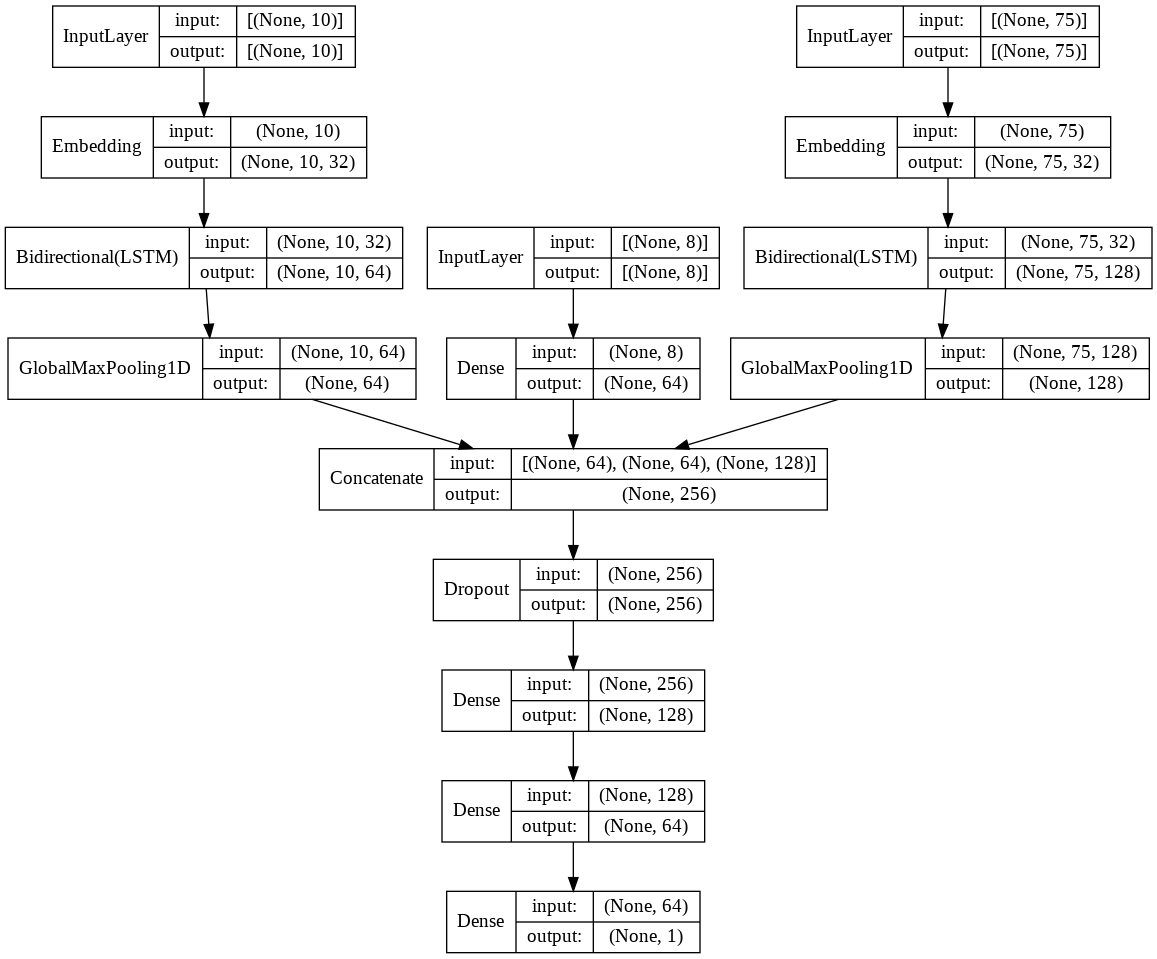

In [ ]:
plot_model(model2, show_layer_names=False, show_shapes=True)

In [ ]:
model2.compile(optimizer=optimizer, loss=loss)

stop_callback = EarlyStopping(monitor='val_loss', patience=patience)
save_callback = ModelCheckpoint(path+'best_model2.h5', save_best_only=True)

net_hist = model2.fit([X_train, name_padded, desc_padded], y_train, epochs=epochs, batch_size=batch_size, 
                      validation_data=([X_val, name_padded_val, desc_padded_val], y_val), callbacks=[stop_callback, save_callback])

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)
plt.plot(net_hist.history['loss'], label='train')
plt.plot(net_hist.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.show()

In [ ]:
model2 = keras.models.load_model(path+'best_model2.h5')

In [ ]:
rmsle = calc_rmsle(model2, [X_test, name_padded_test, desc_padded_test], y_test)
print('rmsle:', np.round(rmsle,5))

# ------> best: rmsle = 0.45613

### Model 3
W2v embedding

In [ ]:
X_train_namedesc = X_train[['name', 'description']]
X_val_namedesc = X_val[['name', 'description']]
X_test_namedesc = X_test[['name', 'description']]

for df in [X_train, X_val, X_test]:
  del df['name'], df['description']

In [ ]:
# normalize in [0,1]
scaler = MinMaxScaler(feature_range = (0, 1))
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

Tokenizer

In [ ]:
tokenizer = Tokenizer()

texts = np.hstack([X_train_namedesc["description"], X_train_namedesc["name"]])
tokenizer.fit_on_texts(texts)

del texts

In [ ]:
word_index = tokenizer.word_index
print(len(word_index)) # non ci sono stringa vuota e carattere di padding

188469


w2v pretrained

In [ ]:
word2vec_path = path+'GoogleNews-vectors-negative300.bin.gz'
w2v_gogol = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

Embedding matrix

In [ ]:
embedding_dim = 300
num_tokens = len(word_index) + 1

embedding_matrix = create_embed_matrix(w2v_gogol, word_index, num_tokens, embedding_dim)

Converted 51956 words (136513 misses)


Converts text to sequence

In [ ]:
name_length_max=10
desc_length_max=75

In [ ]:
def my_tokenize(df):
  d = {
      'name': np.array(tokenizer.texts_to_sequences(df.name.tolist())),
      'description': np.array(tokenizer.texts_to_sequences(df.description.tolist())),
  }
  d["description"] = pad_sequences(d["description"], padding='post', maxlen=desc_length_max)
  d["name"] = pad_sequences(d["name"], padding='post', maxlen=name_length_max)
  return d

X_train_namedesc = my_tokenize(X_train_namedesc)
X_val_namedesc = my_tokenize(X_val_namedesc)
X_test_namedesc = my_tokenize(X_test_namedesc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Model

In [ ]:
epochs = 50
batch_size = 1024
patience = 3
optimizer = 'adam'
loss = mean_squared_logarithmic_error

In [ ]:
def create_model3(X_train):

  # define sets of inputs
  input = Input(shape=(X_train.shape[1],))
  input_name = Input(shape=(name_length_max,), name='name')
  input_desc = Input(shape=(desc_length_max,), name='description')

  # 1st branch
  l1 = Dense(64, activation="relu")(input)
  
  # 2nd branch
  embedded_name = Embedding(input_dim=num_tokens, output_dim=embedding_dim, weights=[embedding_matrix], 
                            input_length=name_length_max, trainable=False)(input_name)
  embedded_name = Bidirectional(LSTM(32, return_sequences=True, dropout=0.2)) (embedded_name)
  embedded_name = GlobalMaxPooling1D()(embedded_name)

  # 3rd branch
  embedded_desc = Embedding(input_dim=num_tokens, output_dim=embedding_dim, weights=[embedding_matrix], 
                            input_length=desc_length_max, trainable=False)(input_desc)
  embedded_desc = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)) (embedded_desc)
  embedded_desc = GlobalMaxPooling1D()(embedded_desc)

  # combine branches
  combined = concatenate([l1, embedded_name, embedded_desc])

  # final layer
  z = Dropout(0.2)(combined)
  z = Dense(128, activation="relu")(z)
  z = Dense(64, activation="relu")(z)
  z = Dense(1, activation="linear")(z)

  return Model(inputs=[input, input_name, input_desc], outputs=z)


model3 = create_model3(X_train)

In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 name (InputLayer)              [(None, 10)]         0           []                               
                                                                                                  
 description (InputLayer)       [(None, 75)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 10, 300)      56541000    ['name[0][0]']                   
                                                                                                  
 embedding_1 (Embedding)        (None, 75, 300)      56541000    ['description[0][0]']            
                                                                                              

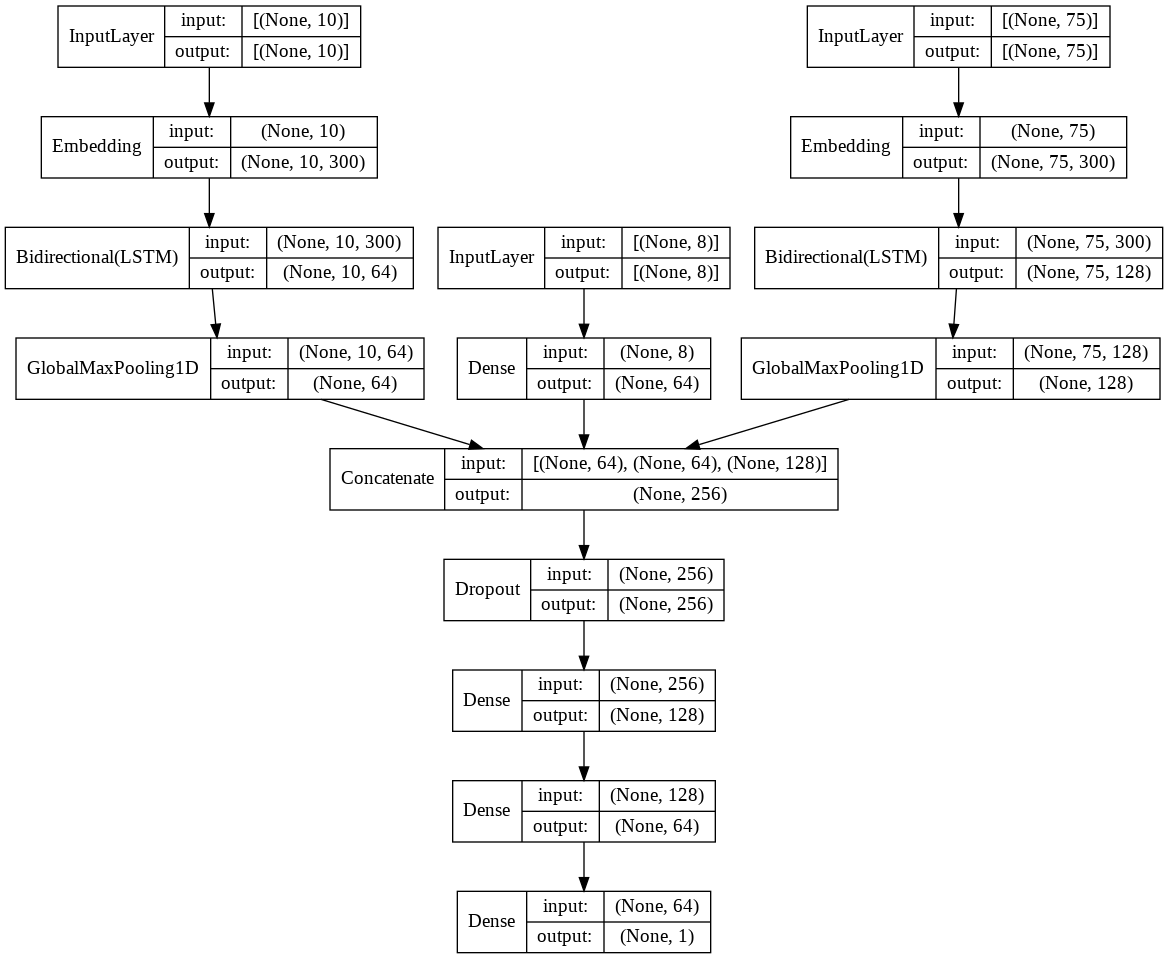

In [ ]:
plot_model(model3, show_layer_names=False, show_shapes=True)

In [ ]:
model3.compile(optimizer=optimizer, loss=loss)

stop_callback = EarlyStopping(monitor='val_loss', patience=patience)
save_callback = ModelCheckpoint(path+'best_model3.h5', save_best_only=True)

net_hist = model3.fit([X_train, X_train_namedesc['name'], X_train_namedesc['description']], y_train, epochs=epochs, batch_size=batch_size, 
                     validation_data=([X_val, X_val_namedesc['name'], X_val_namedesc['description']], y_val), callbacks=[stop_callback, save_callback])

Epoch 1/50
1173/1173 [==============================] - 166s 135ms/step - loss: 0.0320 - val_loss: 0.0205
Epoch 2/50
1173/1173 [==============================] - 159s 136ms/step - loss: 0.0194 - val_loss: 0.0192
Epoch 3/50
1173/1173 [==============================] - 159s 135ms/step - loss: 0.0181 - val_loss: 0.0179
Epoch 4/50
1173/1173 [==============================] - 159s 136ms/step - loss: 0.0174 - val_loss: 0.0175
Epoch 5/50
1173/1173 [==============================] - 163s 139ms/step - loss: 0.0168 - val_loss: 0.0174
Epoch 6/50
1173/1173 [==============================] - 159s 136ms/step - loss: 0.0164 - val_loss: 0.0165
Epoch 7/50
1173/1173 [==============================] - 159s 136ms/step - loss: 0.0160 - val_loss: 0.0161
Epoch 8/50
1173/1173 [==============================] - 159s 135ms/step - loss: 0.0158 - val_loss: 0.0157
Epoch 9/50
1173/1173 [==============================] - 155s 132ms/step - loss: 0.0156 - val_loss: 0.0163
Epoch 10/50
1173/1173 [=======================

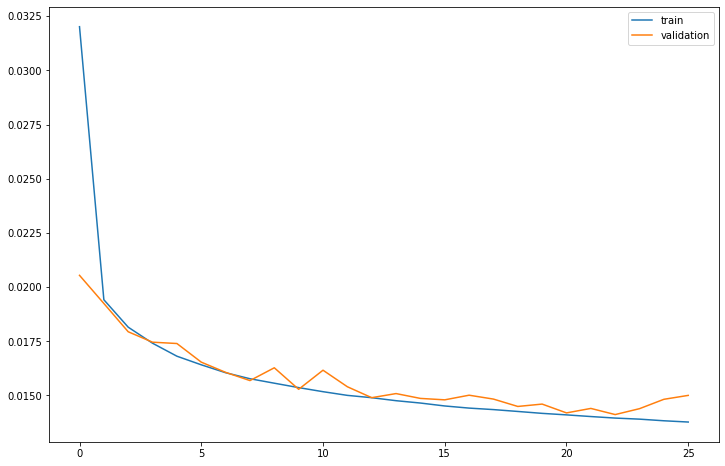

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)
plt.plot(net_hist.history['loss'], label='train')
plt.plot(net_hist.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.show()

In [ ]:
model3 = keras.models.load_model(path+'best_model3.h5')

In [ ]:
rmsle = calc_rmsle(model3, [X_test, X_test_namedesc['name'], X_test_namedesc['description']], y_test)
print('rmsle:', np.round(rmsle,5))

rmsle: 0.46677
